#Web Fetching

In [ ]:
!apt-get update
!apt-get install -y wget unzip


!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb || apt-get -fy install

!rm -f /usr/bin/chromedriver

!LATEST_VERSION=$(curl -sS https://chromedriver.storage.googleapis.com/LATEST_RELEASE) && \
wget https://chromedriver.storage.googleapis.com/$LATEST_VERSION/chromedriver_linux64.zip

!unzip -o chromedriver_linux64.zip
!mv chromedriver /usr/bin/chromedriver
!chmod +x /usr/bin/chromedriver

!google-chrome --version
!chromedriver --version


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,110 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,482 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
import pandas as pd
import datetime
import re

def create_next_week(url, end_date):
    query_date = '[0-9]{4}-[0-9]{2}-[0-9]{2}'
    match = re.search(query_date, url)
    if match:
        span = match.span()
        time_obj = datetime.datetime.strptime(url[span[0]:span[1]], '%Y-%m-%d')
        new_date = time_obj + datetime.timedelta(days=7)
        if new_date > datetime.datetime.strptime(end_date, '%Y-%m-%d'):
            return None  #stop when the end date is reached
        new_date_str = new_date.strftime('%Y-%m-%d')
        return url.replace(url[span[0]:span[1]], new_date_str)
    return None


data = pd.DataFrame()

start_date = '2023-01-01'
end_date = '2024-12-31'
url = f"https://www.visualcrossing.com/weather/weather-data-services/Amman,Jordan/metric/{start_date}/{end_date}"


chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.binary_location = '/usr/bin/google-chrome'
service = Service('/usr/bin/chromedriver')
browser = webdriver.Chrome(service=service, options=chrome_options)

while url:
    browser.get(url)
    try:
        WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'table-responsive')))
        table = browser.find_element(By.CLASS_NAME, 'table-responsive')
        rows = table.find_elements(By.TAG_NAME, 'tr')

        if data.empty:
            headers = [col.text for col in rows[0].find_elements(By.TAG_NAME, 'th')]
            data = pd.DataFrame(columns=headers)

        weekly_data = []
        for row in rows[1:]:  #skip header row
            cols = row.find_elements(By.TAG_NAME, 'td')
            row_data = [col.text for col in cols]

            if len(row_data) < len(headers):
                row_data.extend([''] * (len(headers) - len(row_data)))  #fill missing columns
            elif len(row_data) > len(headers):
                row_data = row_data[:len(headers)]  #trim extra columns

            weekly_data.append(row_data)

        weekly_df = pd.DataFrame(weekly_data, columns=data.columns)
        data = pd.concat([data, weekly_df], ignore_index=True)

    except TimeoutException:
        print(f"Timed out on URL: {url}")
        break

    data.to_csv('weather_data_recent.csv', index=False)
    url = create_next_week(url, end_date)

browser.quit()
print("Data collection completed!")


Data collection completed!


In [ ]:
import pandas as pd
data = pd.read_csv('weather_data_recent.csv')
print(data.head())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 34 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   0 non-null      float64
 1   Unnamed: 1   0 non-null      float64
 2   Unnamed: 2   0 non-null      float64
 3   Unnamed: 3   0 non-null      float64
 4   Unnamed: 4   0 non-null      float64
 5   Unnamed: 5   0 non-null      float64
 6   Unnamed: 6   0 non-null      float64
 7   Unnamed: 7   0 non-null      float64
 8   Unnamed: 8   0 non-null      float64
 9   Unnamed: 9   0 non-null      float64
 10  Unnamed: 10  0 non-null      float64
 11  Unnamed: 11  0 non-null      float64
 12  Unnamed: 12  0 non-null      float64
 13  Unnamed: 13  0 non-null      float64
 14  Unnamed: 14  0 non-null      float64
 15  Unnamed: 15  0 non-null      float64
 16  Unnamed: 16  0 non-null      float64
 17  Unnamed: 17  0 non-null      float64
 18  Unnamed: 18  0 non-null      float64
 19  Unname

Well.. i failed :P

In [ ]:
import requests
from datetime import datetime, timedelta

def fetch_weather_data(api_key, location, start_date, end_date, unit_group="metric"):
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{location}/{start_date}/{end_date}"
    params = {
        "unitGroup": unit_group,
        "key": api_key,
        "include": "days",
        "contentType": "csv"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        print(f"Data fetched for {start_date} to {end_date}")
        from io import StringIO
        return pd.read_csv(StringIO(response.text))
    else:
        print(f"Failed to fetch data for {start_date} to {end_date}: {response.status_code}")
        return pd.DataFrame()  # Return an empty DataFrame on failure

api_key = "B6DXC22JWZSKVBCHEDRG5ATPB"
location = "Amman,Jordan"
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 12, 31)
chunk_size = 30  # of days per request

all_data = pd.DataFrame()

current_date = start_date

while current_date < end_date:
    next_date = current_date + timedelta(days=chunk_size - 1)
    if next_date > end_date:
        next_date = end_date

    df = fetch_weather_data(
        api_key=api_key,
        location=location,
        start_date=current_date.strftime("%Y-%m-%d"),
        end_date=next_date.strftime("%Y-%m-%d")
    )

    if not df.empty:
        all_data = pd.concat([all_data, df], ignore_index=True)

    current_date = next_date + timedelta(days=1)

all_data.to_csv("weather_data_jordan.csv", index=False)
print("Data collection completed!")


Data fetched for 2022-01-01 to 2022-01-30
Data fetched for 2022-01-31 to 2022-03-01
Data fetched for 2022-03-02 to 2022-03-31
Data fetched for 2022-04-01 to 2022-04-30
Data fetched for 2022-05-01 to 2022-05-30
Data fetched for 2022-05-31 to 2022-06-29
Data fetched for 2022-06-30 to 2022-07-29
Data fetched for 2022-07-30 to 2022-08-28
Data fetched for 2022-08-29 to 2022-09-27
Data fetched for 2022-09-28 to 2022-10-27
Data fetched for 2022-10-28 to 2022-11-26
Data fetched for 2022-11-27 to 2022-12-26
Data fetched for 2022-12-27 to 2023-01-25
Data fetched for 2023-01-26 to 2023-02-24
Data fetched for 2023-02-25 to 2023-03-26
Data fetched for 2023-03-27 to 2023-04-25
Data fetched for 2023-04-26 to 2023-05-25
Data fetched for 2023-05-26 to 2023-06-24
Data fetched for 2023-06-25 to 2023-07-24
Data fetched for 2023-07-25 to 2023-08-23
Data fetched for 2023-08-24 to 2023-09-22
Data fetched for 2023-09-23 to 2023-10-22
Data fetched for 2023-10-23 to 2023-11-21
Data fetched for 2023-11-22 to 202

# Getting the data ready --> generative ai for data generation

aiming for generating 50k+ ? dataset from 1k rows dataset (i just like to suffer)

In [139]:
data = pd.read_csv('weather_data_jordan.csv')
data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Ø¹Ù Ø§Ù, Ø§ÙØ£Ø±Ø¯Ù",2022-01-01,11.0,8.1,9.6,11.0,7.2,9.1,7.1,85.4,...,4.4,3.0,NaN,2022-01-01T06:36:47,2022-01-01T16:42:53,0.95,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"40183099999,C0641,40270099999,OJAM,OJAI,402720..."
1,"Ø¹Ù Ø§Ù, Ø§ÙØ£Ø±Ø¯Ù",2022-01-02,13.0,8.7,10.1,13.0,7.6,9.7,8.1,88.2,...,8.3,5.0,NaN,2022-01-02T06:37:00,2022-01-02T16:43:37,0.00,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"40183099999,C0641,40270099999,OJAM,OJAI,402720..."
2,"Ø¹Ù Ø§Ù, Ø§ÙØ£Ø±Ø¯Ù",2022-01-03,13.0,8.0,10.2,13.0,5.5,9.4,6.3,78.5,...,9.9,5.0,NaN,2022-01-03T06:37:11,2022-01-03T16:44:22,0.02,"Rain, Partially cloudy",Partly cloudy throughout the day with rain cle...,rain,"40183099999,C0641,40270099999,OJAM,OJAI,402720..."
3,"Ø¹Ù Ø§Ù, Ø§ÙØ£Ø±Ø¯Ù",2022-01-04,13.0,6.8,9.7,13.0,4.7,9.0,6.7,81.9,...,9.8,6.0,NaN,2022-01-04T06:37:20,2022-01-04T16:45:08,0.05,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"40183099999,C0641,40270099999,OJAM,OJAI,402720..."
4,"Ø¹Ù Ø§Ù, Ø§ÙØ£Ø±Ø¯Ù",2022-01-05,14.0,8.9,10.8,14.0,6.9,10.3,7.3,79.4,...,6.1,3.0,NaN,2022-01-05T06:37:27,2022-01-05T16:45:55,0.09,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"40183099999,C0641,40270099999,OJAM,OJAI,402720..."


In [140]:
print(data.describe())

           tempmax      tempmin         temp  feelslikemax  feelslikemin  \
count  1096.000000  1096.000000  1096.000000   1096.000000   1096.000000   
mean     24.436314    14.263412    19.105748     23.374088     13.668248   
std       8.389283     6.539376     7.381264      8.770035      7.373467   
min       4.000000    -0.200000     2.000000      0.000000     -6.900000   
25%      17.100000     8.200000    12.300000     17.075000      7.375000   
50%      25.200000    14.650000    19.900000     25.200000     14.650000   
75%      31.200000    19.900000    25.525000     30.300000     19.900000   
max      42.900000    28.700000    34.800000     44.900000     28.900000   

         feelslike          dew     humidity       precip   precipprob  ...  \
count  1096.000000  1096.000000  1096.000000  1096.000000  1096.000000  ...   
mean     18.556661     7.603832    53.009124     0.639904    17.465511  ...   
std       7.723671     4.495616    17.658221     3.105927    37.837612  ...   

In [141]:
numeric_cols = ['snow', 'snowdepth', 'windgust', 'solarradiation', 'solarenergy', 'uvindex']
for col in numeric_cols:
    data[col].fillna(data[col].mean(), inplace=True)

categorical_cols = ['preciptype','stations']
for col in categorical_cols:
    data[col].fillna('unknown', inplace=True)

data.drop(columns=['severerisk', 'name', 'icon', 'description'], inplace=True)

<ipython-input-141-17bfc0d5e0c6>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
<ipython-input-141-17bfc0d5e0c6>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [142]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          1096 non-null   object 
 1   tempmax           1096 non-null   float64
 2   tempmin           1096 non-null   float64
 3   temp              1096 non-null   float64
 4   feelslikemax      1096 non-null   float64
 5   feelslikemin      1096 non-null   float64
 6   feelslike         1096 non-null   float64
 7   dew               1096 non-null   float64
 8   humidity          1096 non-null   float64
 9   precip            1096 non-null   float64
 10  precipprob        1096 non-null   float64
 11  precipcover       1096 non-null   float64
 12  preciptype        1096 non-null   object 
 13  snow              1096 non-null   float64
 14  snowdepth         1096 non-null   float64
 15  windgust          1096 non-null   float64
 16  windspeed         1096 non-null   float64


In [143]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['sunrise'] = pd.to_datetime(data['sunrise'], format='%H:%M:%S', errors='coerce')
data['sunset'] = pd.to_datetime(data['sunset'], format='%H:%M:%S', errors='coerce')

data['day_of_week'] = data['datetime'].dt.dayofweek  #0=monday, 6=sunday
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour

In [147]:
print(data.isnull().sum())

datetime            0
tempmax             0
tempmin             0
temp                0
feelslikemax        0
feelslikemin        0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
precipcover         0
preciptype          0
snow                0
snowdepth           0
windgust            0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
moonphase           0
conditions          0
stations            0
day_of_week         0
month               0
hour                0
dtype: int64


In [ ]:
data.drop(columns=['sunrise', 'sunset'], inplace=True)

In [150]:
preciptype_dummies = pd.get_dummies(data['preciptype'], prefix='preciptype')
data = pd.concat([data, preciptype_dummies], axis=1)
data.drop(columns=['preciptype'], inplace=True)

In [154]:
print(data['conditions'].unique())

['Rain, Partially cloudy' 'Partially cloudy' 'Clear'
 'Snow, Rain, Partially cloudy' 'Rain' 'Rain, Overcast' 'Overcast']


In [155]:
data['simplified_conditions'] = data['conditions'].str.split(',').str[0]
conditions_dummies = pd.get_dummies(data['simplified_conditions'], prefix='conditions')
data = pd.concat([data, conditions_dummies], axis=1)
data.drop(columns=['conditions'], inplace=True)

print(data.head())

    datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
0 2022-01-01     11.0      8.1   9.6          11.0           7.2        9.1   
1 2022-01-02     13.0      8.7  10.1          13.0           7.6        9.7   
2 2022-01-03     13.0      8.0  10.2          13.0           5.5        9.4   
3 2022-01-04     13.0      6.8   9.7          13.0           4.7        9.0   
4 2022-01-05     14.0      8.9  10.8          14.0           6.9       10.3   

   dew  humidity  precip  ...  preciptype_rain  preciptype_rain,snow  \
0  7.1      85.4   0.516  ...             True                 False   
1  8.1      88.2   0.099  ...             True                 False   
2  6.3      78.5   1.134  ...             True                 False   
3  6.7      81.9   1.094  ...             True                 False   
4  7.3      79.4   0.000  ...            False                 False   

   preciptype_snow  preciptype_unknown  simplified_conditions  \
0            False         

In [156]:
data.drop(columns=['simplified_conditions'], inplace=True)

In [157]:
from sklearn.preprocessing import StandardScaler
numeric_columns = data.select_dtypes(include=['float64', 'int32', 'int64']).columns

scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [158]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   datetime                     1096 non-null   datetime64[ns]
 1   tempmax                      1096 non-null   float64       
 2   tempmin                      1096 non-null   float64       
 3   temp                         1096 non-null   float64       
 4   feelslikemax                 1096 non-null   float64       
 5   feelslikemin                 1096 non-null   float64       
 6   feelslike                    1096 non-null   float64       
 7   dew                          1096 non-null   float64       
 8   humidity                     1096 non-null   float64       
 9   precip                       1096 non-null   float64       
 10  precipprob                   1096 non-null   float64       
 11  precipcover                  1096 non-null 

In [160]:
print(data['stations'].unique())

['40183099999,C0641,40270099999,OJAM,OJAI,40272099999'
 '40183099999,C0641,40270099999,OJAM,OJAI,40272099999,remote'
 'C0641,40183099999,40270099999,OJAM,OJAI,40272099999'
 'C0641,40183099999,40270099999,OJAM,OJAI,40272099999,remote'
 'C0641,40183099999,40270099999,OJAM,OJAI,remote,40272099999'
 'C0641,40183099999,40270099999,OJAM,OJAI,40265099999,40255099999,40272099999'
 'C0641,40183099999,40270099999,OJAM,OJAI,40265099999,40272099999'
 'C0641,OJAM,OJAI'
 'C0641,40183099999,40270099999,OJAM,OJAI,40265099999,40255099999,40272099999,remote'
 'C0641,40183099999,40270099999,OJAM,OJAI,40265099999,40272099999,remote'
 '40183099999,C0641,40270099999,OJAM,OJAI,40265099999,40272099999'
 'C0641,40183099999,40270099999,OJAM,OJAI,40255099999,40265099999,40272099999'
 'C0641,40183099999,40270099999,OJAM,OJAI,40255099999,40272099999'
 'unknown']


In [161]:
#i will just drop it idk why i didnt drop it earlier (im hungry wallah)
data.drop(columns=['stations'], inplace=True)

In [167]:
print(data.describe())

                  datetime       tempmax       tempmin          temp  \
count                 1096  1.096000e+03  1.096000e+03  1.096000e+03   
mean   2023-07-02 12:00:00  1.944916e-16 -1.685594e-16  2.204238e-16   
min    2022-01-01 00:00:00 -2.437115e+00 -2.212752e+00 -2.318513e+00   
25%    2022-10-01 18:00:00 -8.748856e-01 -9.276391e-01 -9.224511e-01   
50%    2023-07-02 12:00:00  9.107271e-02  5.914388e-02  1.076529e-01   
75%    2024-04-01 06:00:00  8.065974e-01  8.623393e-01  8.700654e-01   
max    2024-12-31 00:00:00  2.201871e+00  2.208648e+00  2.127199e+00   
std                    NaN  1.000457e+00  1.000457e+00  1.000457e+00   

       feelslikemax  feelslikemin     feelslike           dew      humidity  \
count  1.096000e+03  1.096000e+03  1.096000e+03  1.096000e+03  1.096000e+03   
mean   1.944916e-17 -3.889832e-17  3.111866e-16  5.186443e-17  1.231780e-16   
min   -2.666438e+00 -2.790768e+00 -2.753401e+00 -4.095598e+00 -1.977836e+00   
25%   -7.185790e-01 -8.538888e-01 -

In [168]:
data.drop(columns=['hour'], inplace=True)

data['year'] = data['datetime'].dt.year
data['day_of_year'] = data['datetime'].dt.dayofyear
data['is_weekend'] = data['datetime'].dt.dayofweek >= 5
data.drop(columns=['datetime'], inplace=True)

# I guess now visualization fixing outliers and visualization.

In [196]:
def detect_outliers_iqr(df):
    outlier_counts = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)
    return outlier_counts

outliers_dict = detect_outliers_iqr(data)
print(f"Number of outliers for each feature: {outliers_dict}")

Number of outliers for each feature: {'tempmax': 0, 'tempmin': 0, 'temp': 0, 'feelslikemax': 0, 'feelslikemin': 0, 'feelslike': 0, 'dew': 6, 'humidity': 0, 'precip': 221, 'precipprob': 202, 'precipcover': 192, 'snow': 33, 'snowdepth': 38, 'windgust': 25, 'windspeed': 25, 'winddir': 190, 'sealevelpressure': 0, 'cloudcover': 13, 'visibility': 23, 'solarradiation': 0, 'solarenergy': 0, 'uvindex': 21, 'moonphase': 0, 'day_of_week': 0, 'month': 0}


# seeing whats going on with:

- high outliers count:

    'precip': 221

    'precipprob': 202

    'precipcover': 192

    'winddir': 190

- moderate outliers count:

    'snowdepth': 38

    'snow': 33

    'windgust': 25

    'windspeed': 25

    'visibility': 23

    'uvindex': 21

- low outliers count:

    'cloudcover': 13
    
    'dew': 6

    

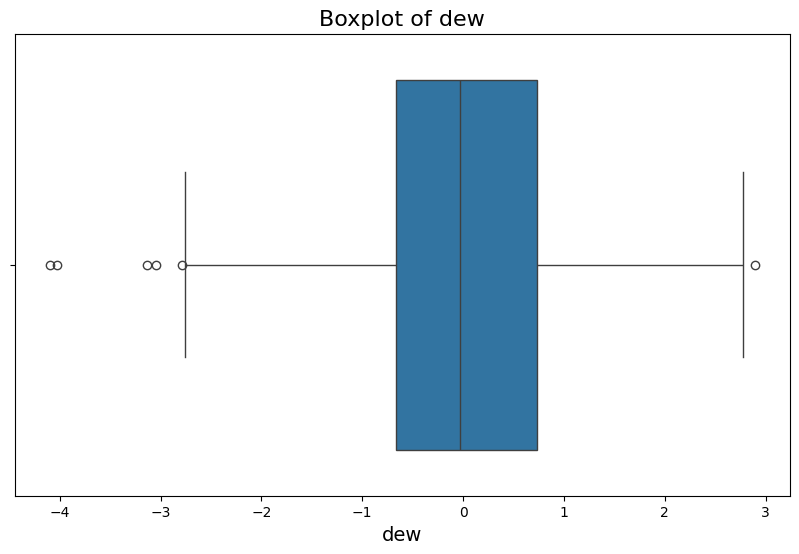

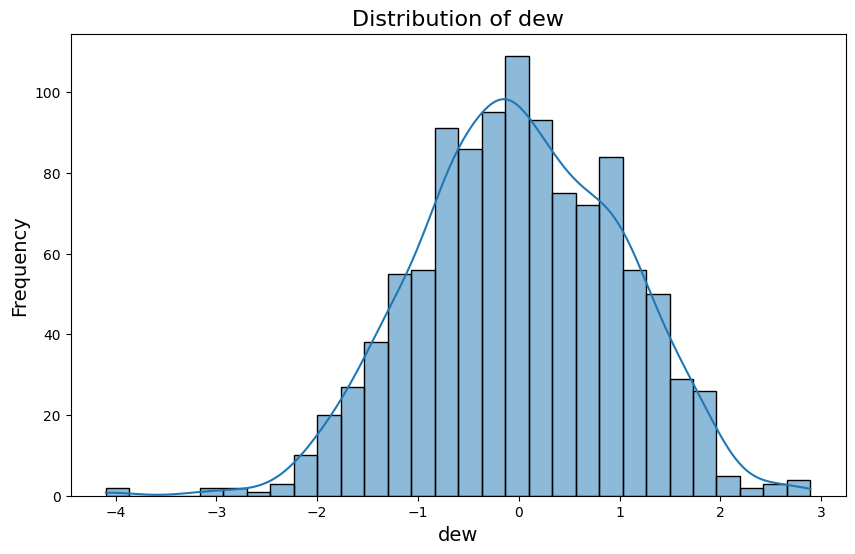

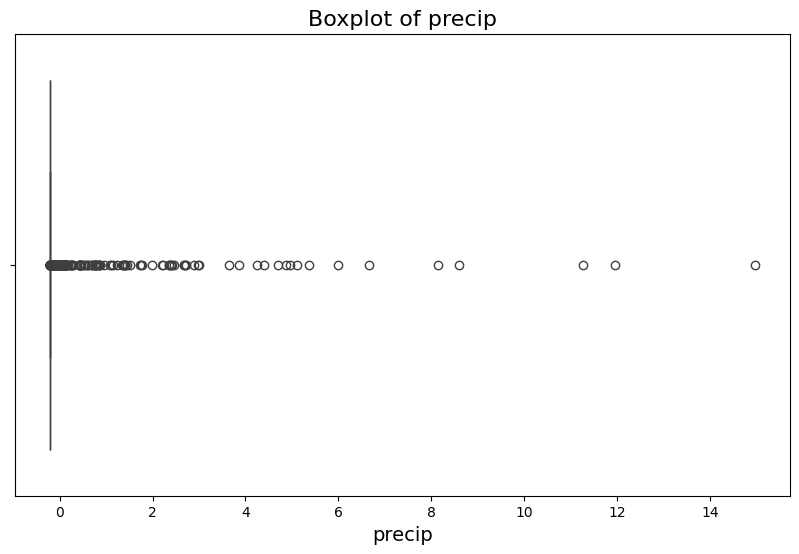

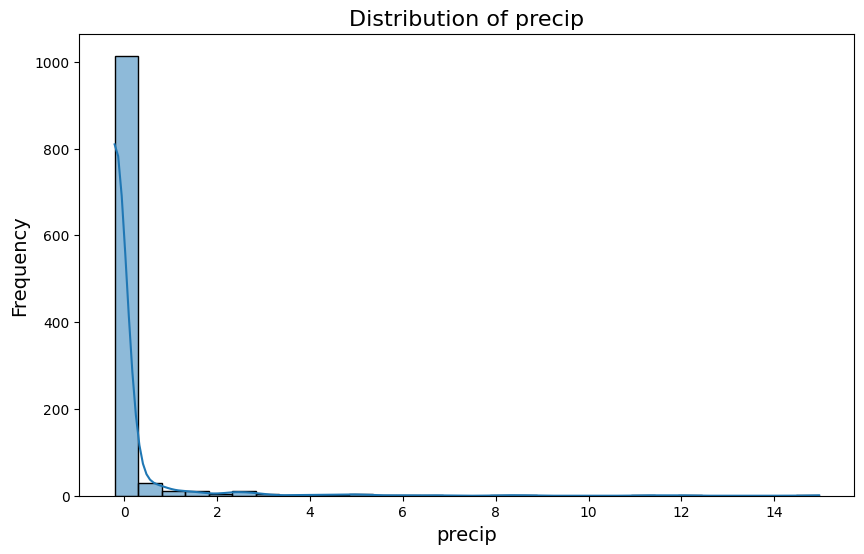

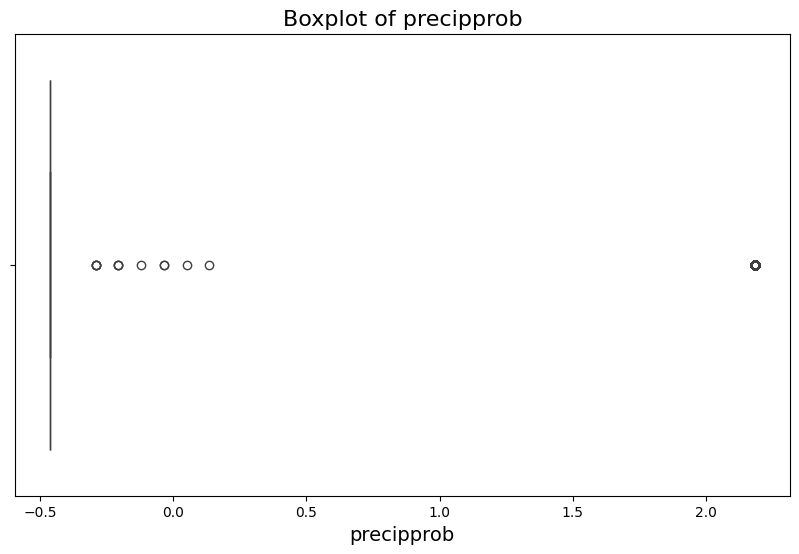

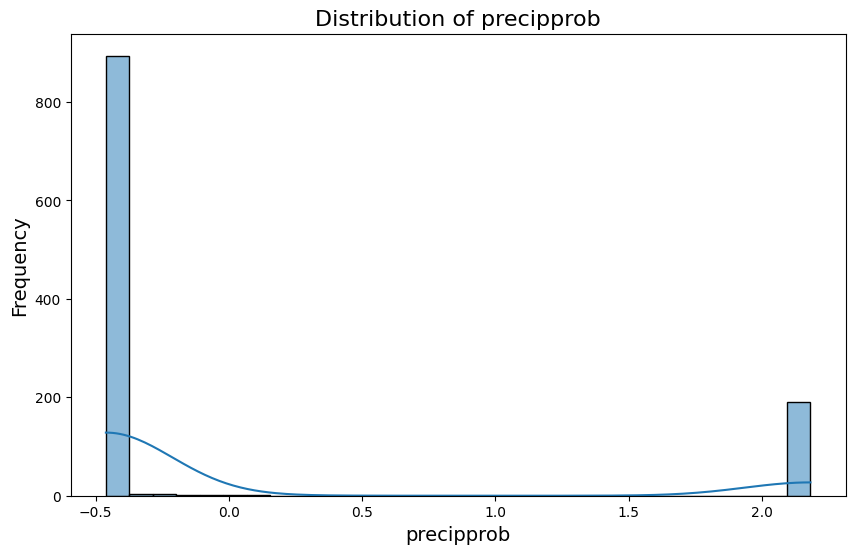

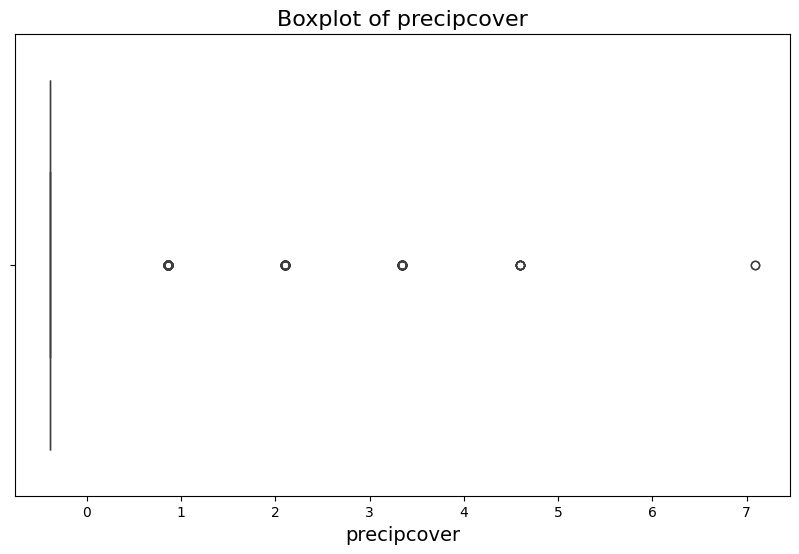

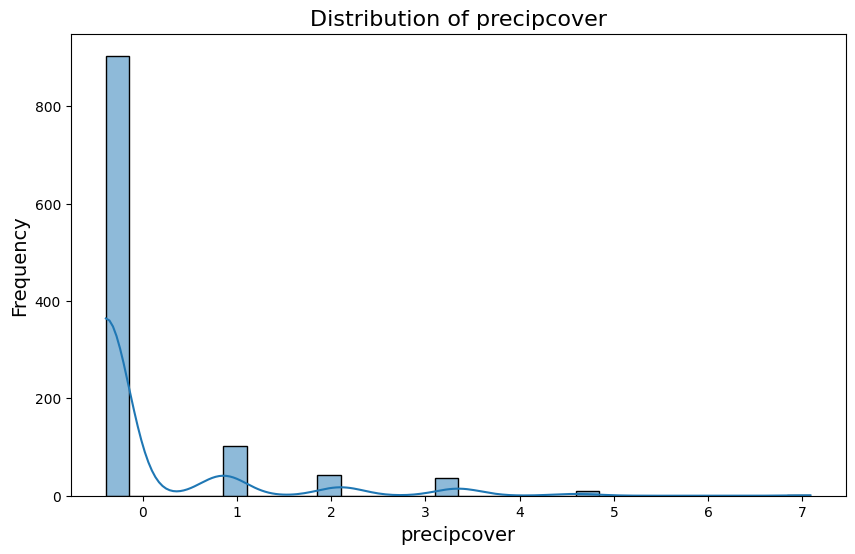

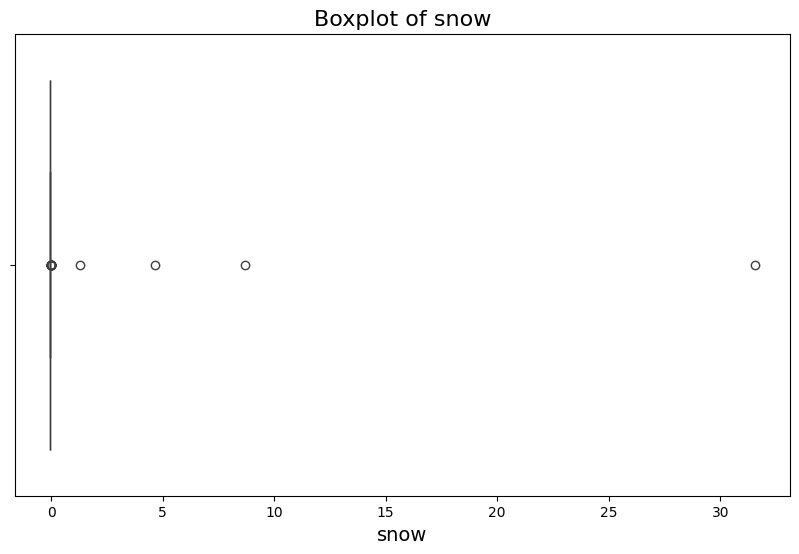

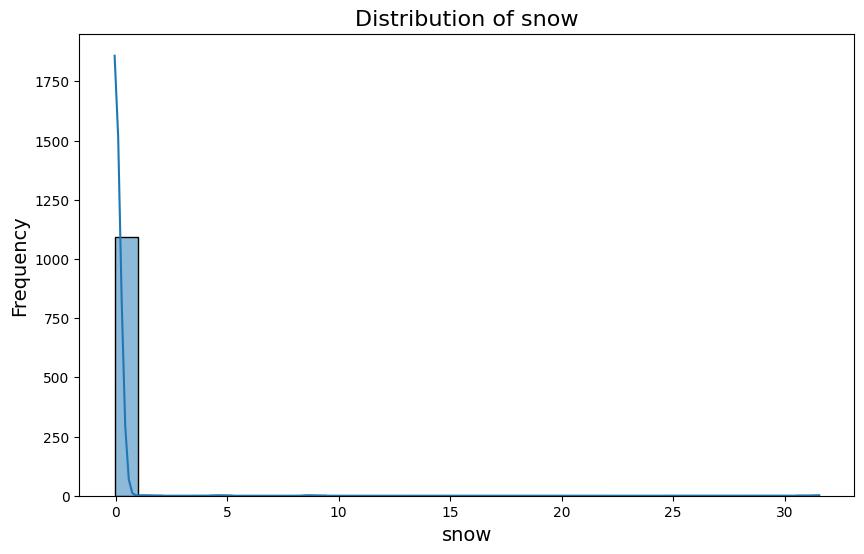

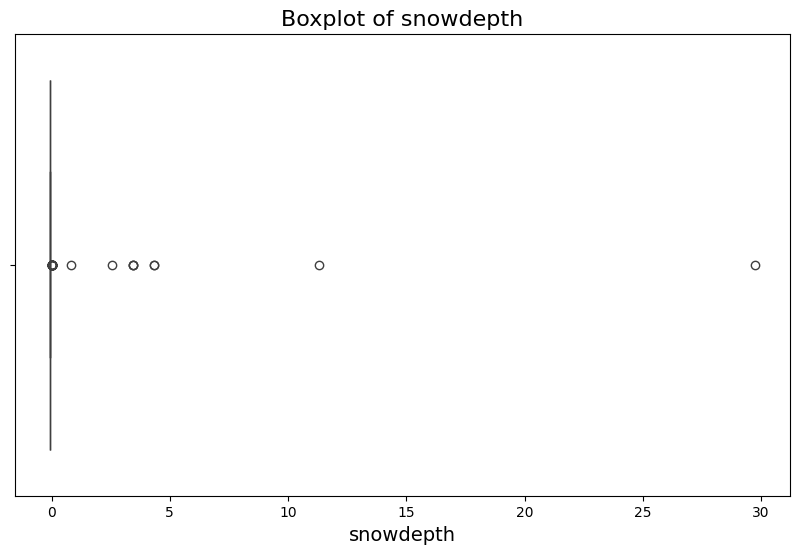

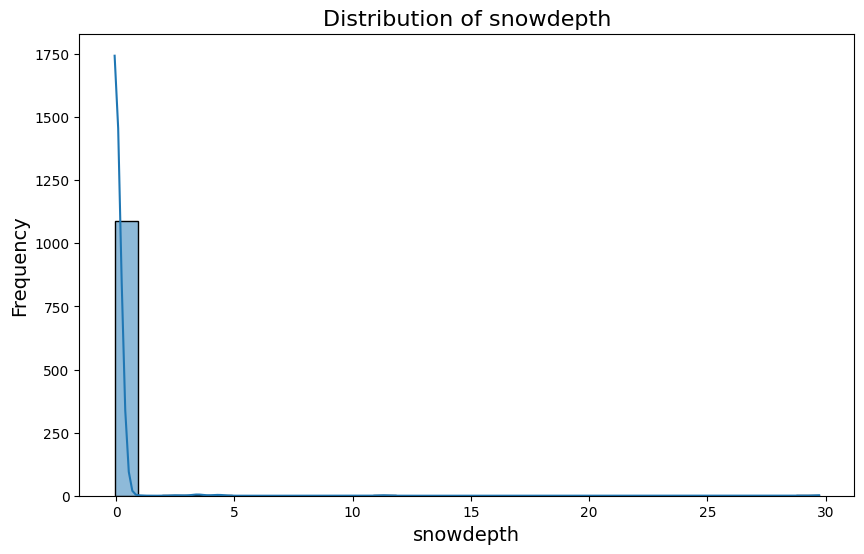

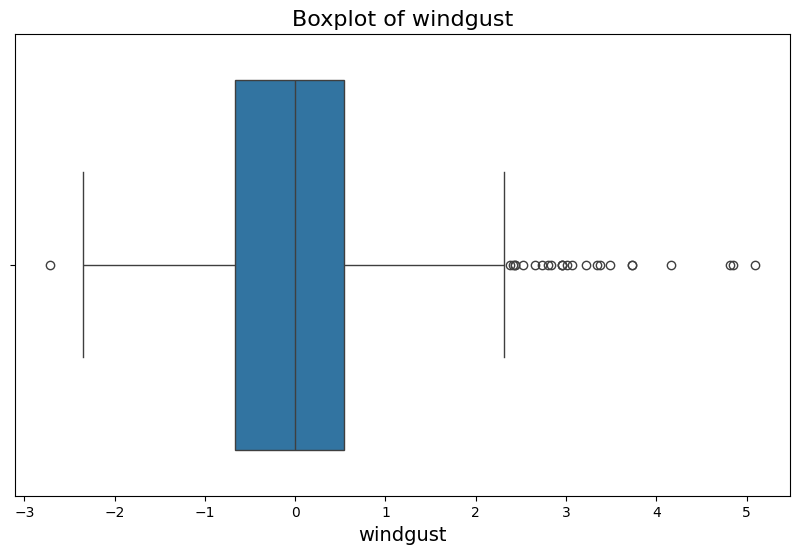

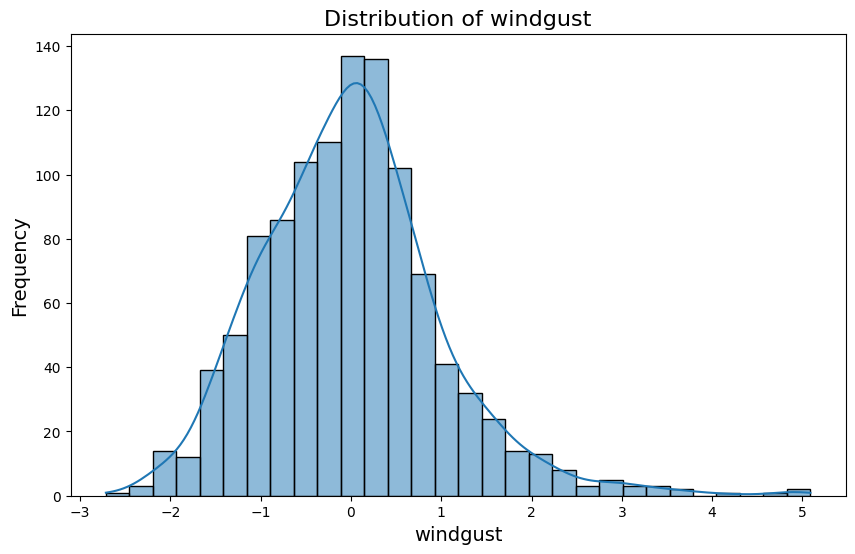

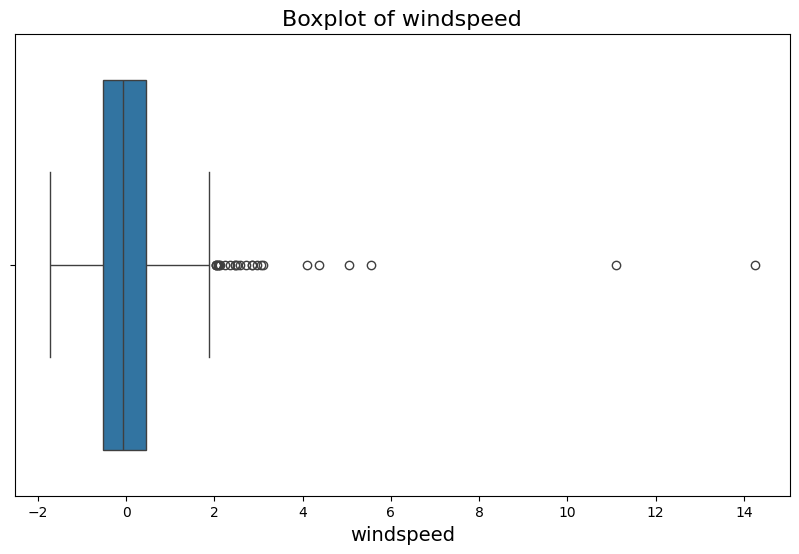

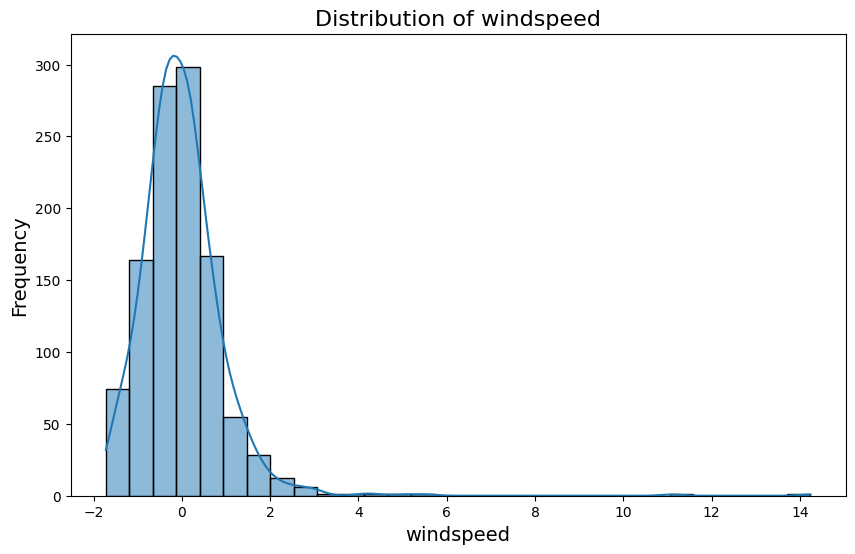

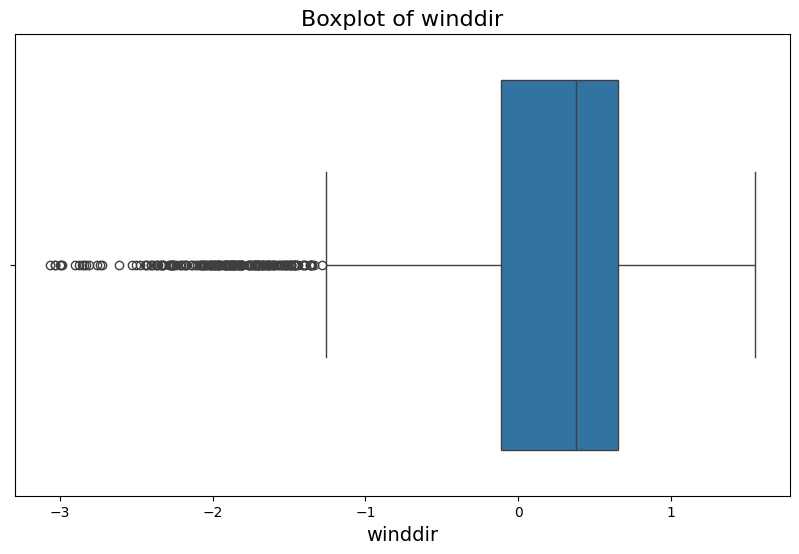

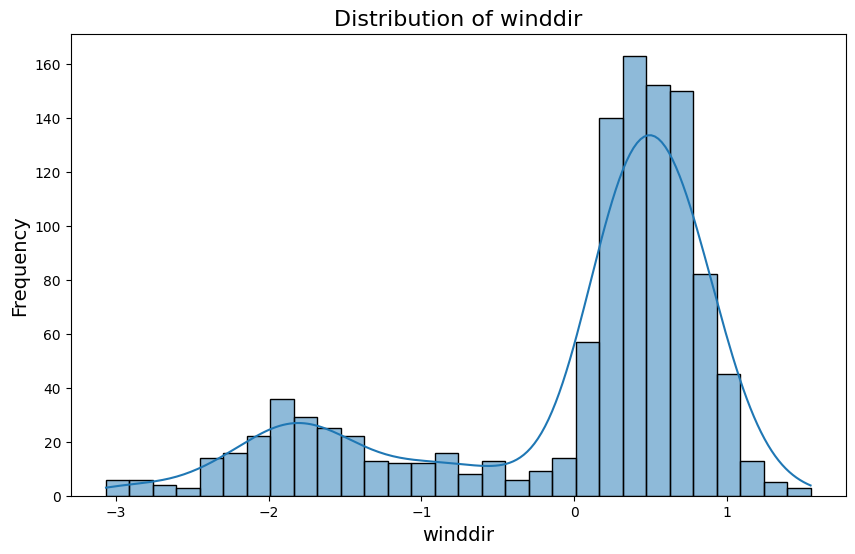

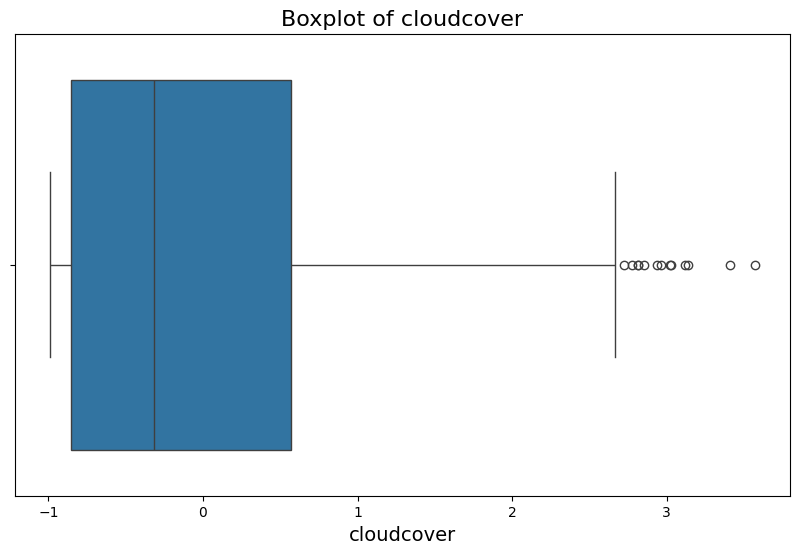

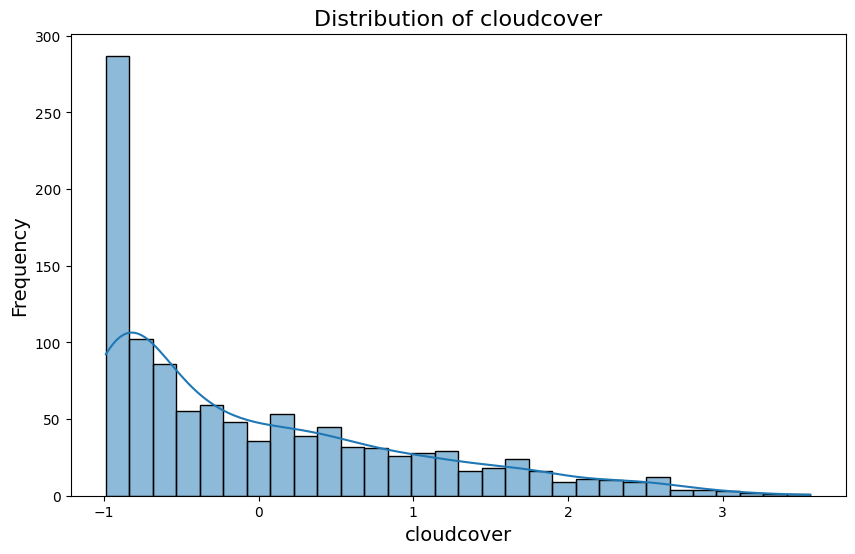

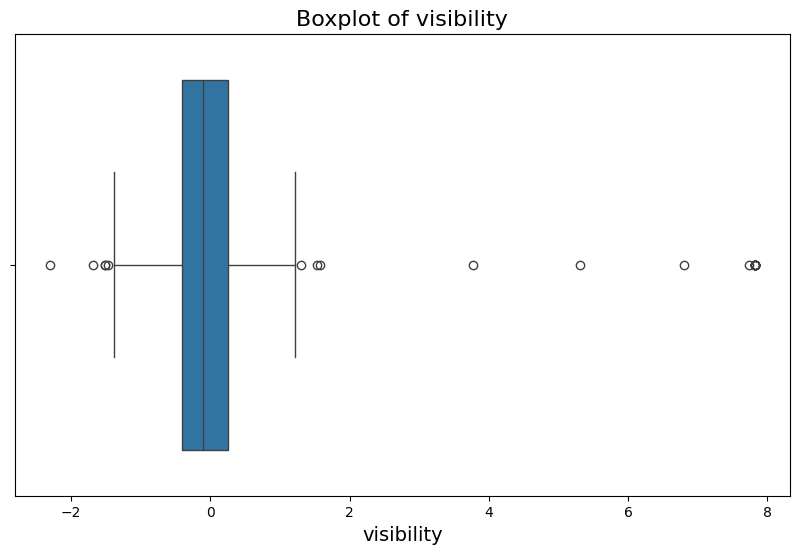

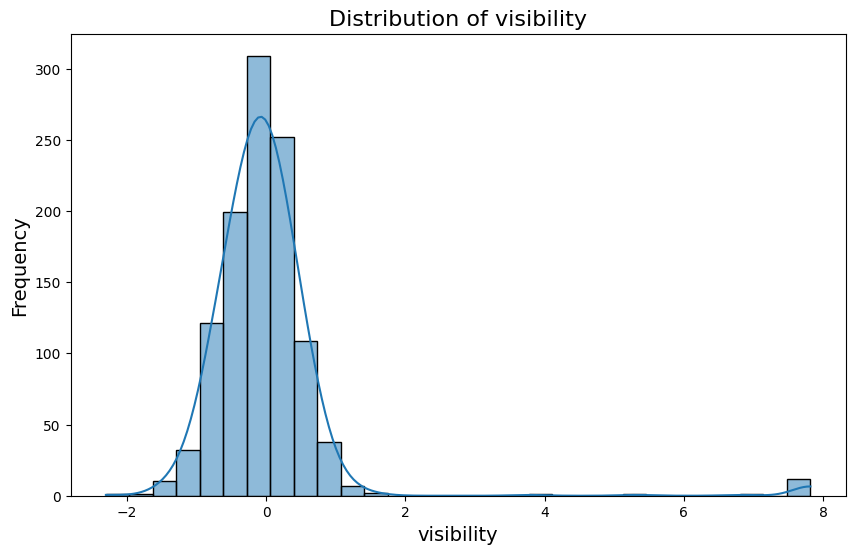

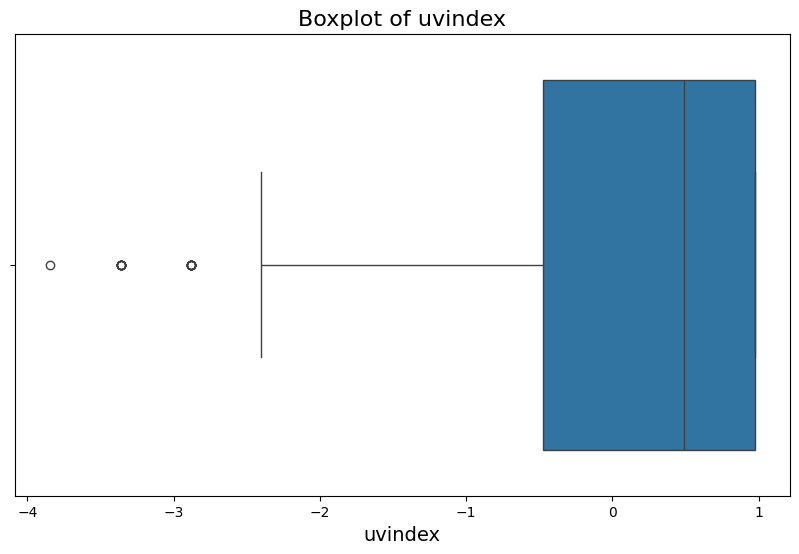

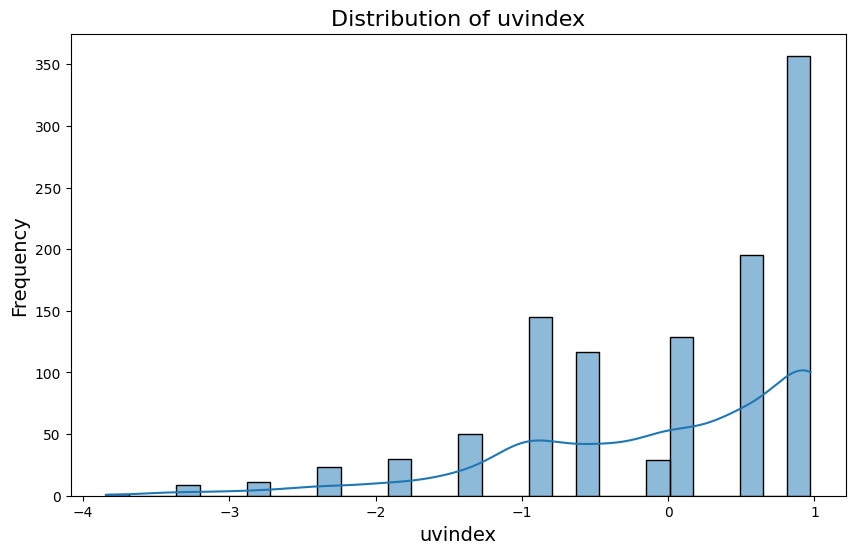

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_outliers(data, columns):
    for col in columns:
        plt.figure(figsize=(10, 6))

        # Boxplot for Outliers
        sns.boxplot(x=data[col])
        plt.title(f'Boxplot of {col}', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.show()

        # Histogram for Distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(data[col], bins=30, kde=True)
        plt.title(f'Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.show()

columns_with_outliers = [col for col, count in outliers_dict.items() if count > 0]
visualize_outliers(data, columns_with_outliers)


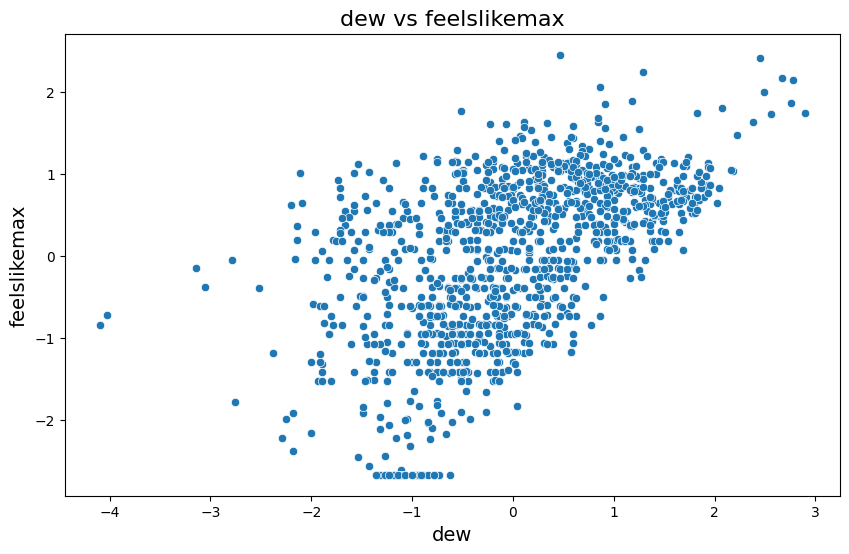

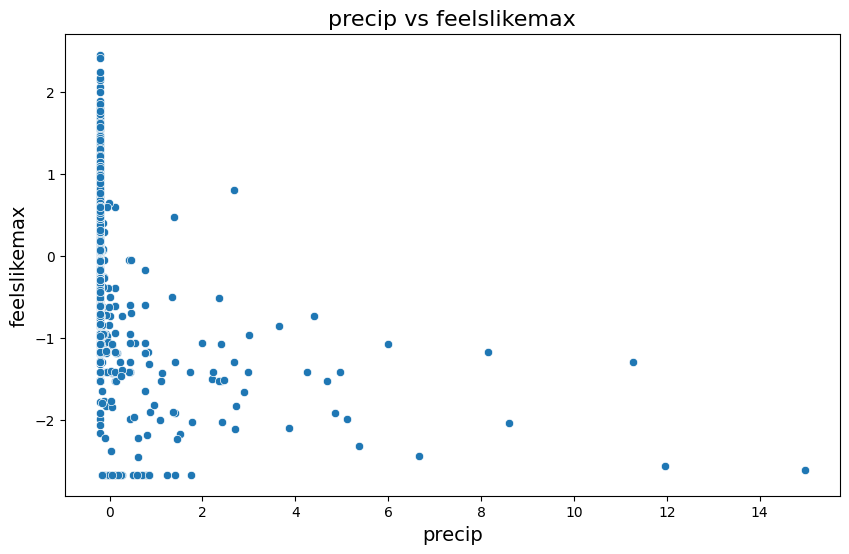

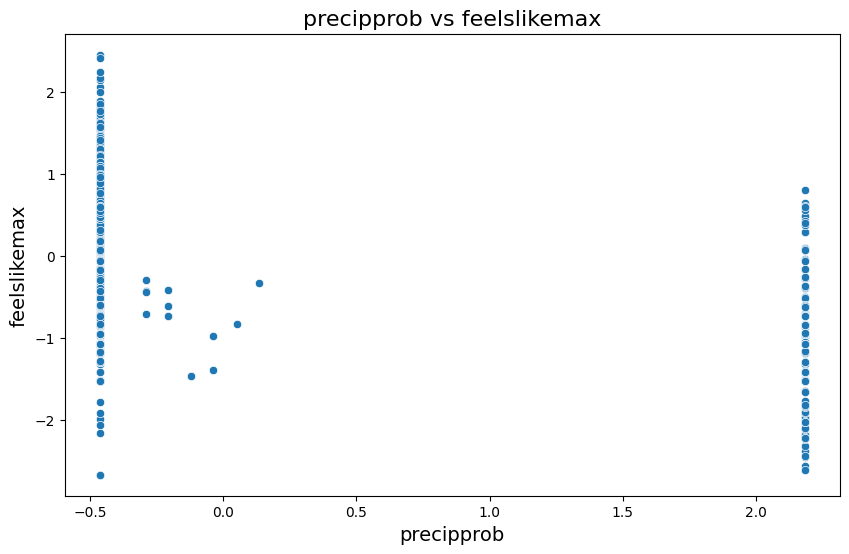

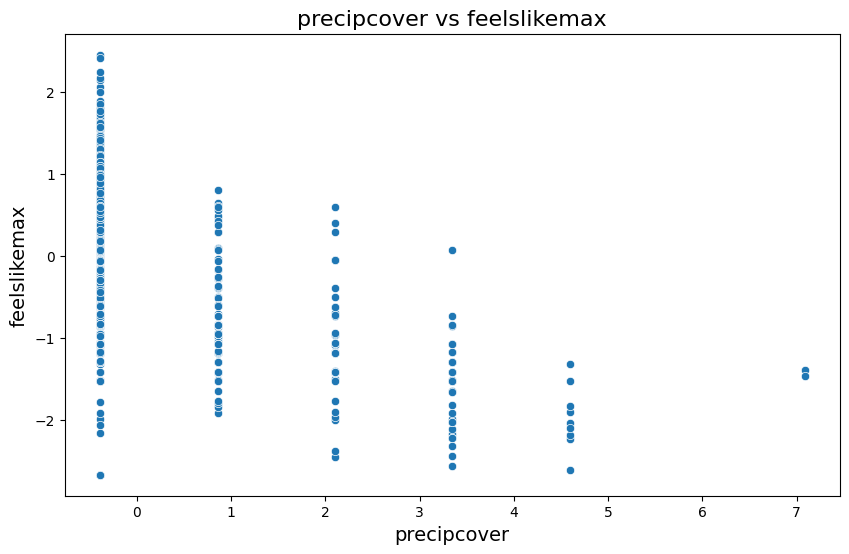

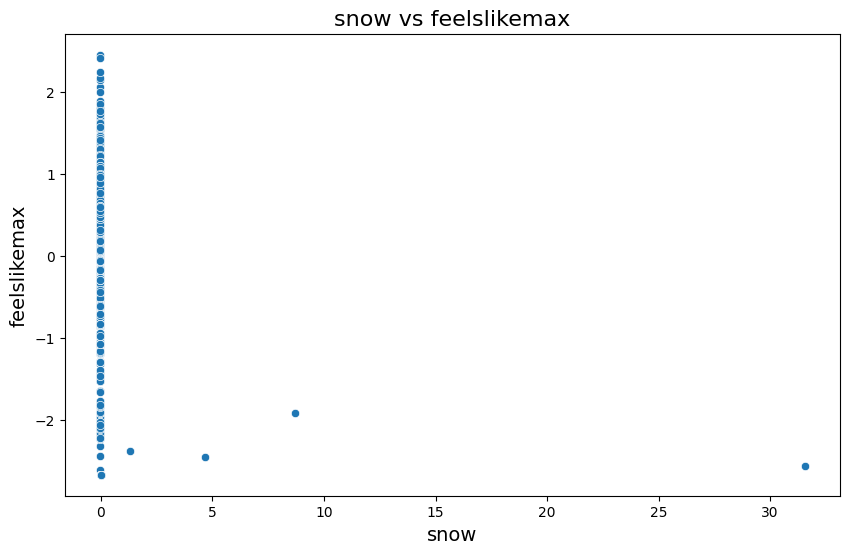

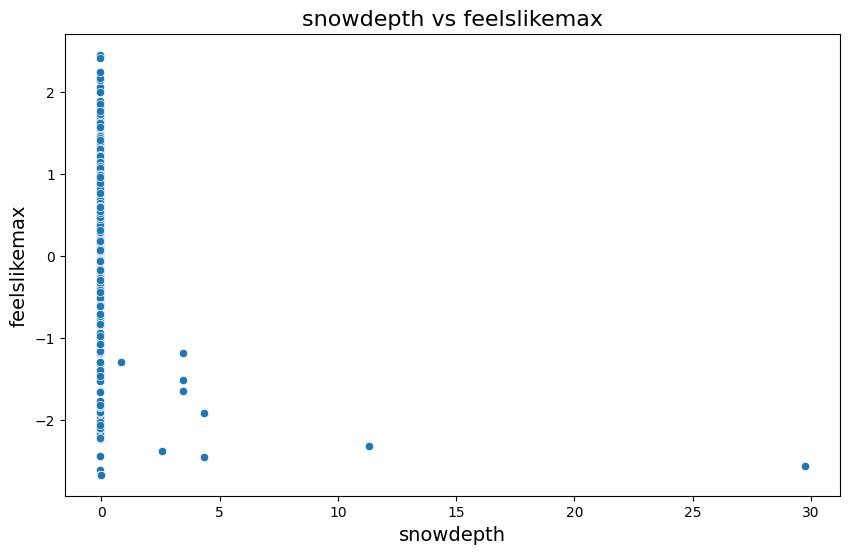

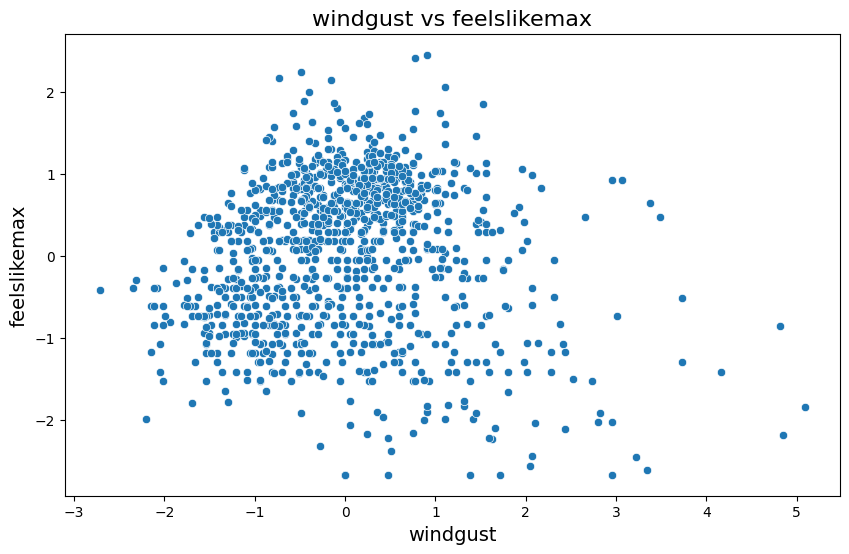

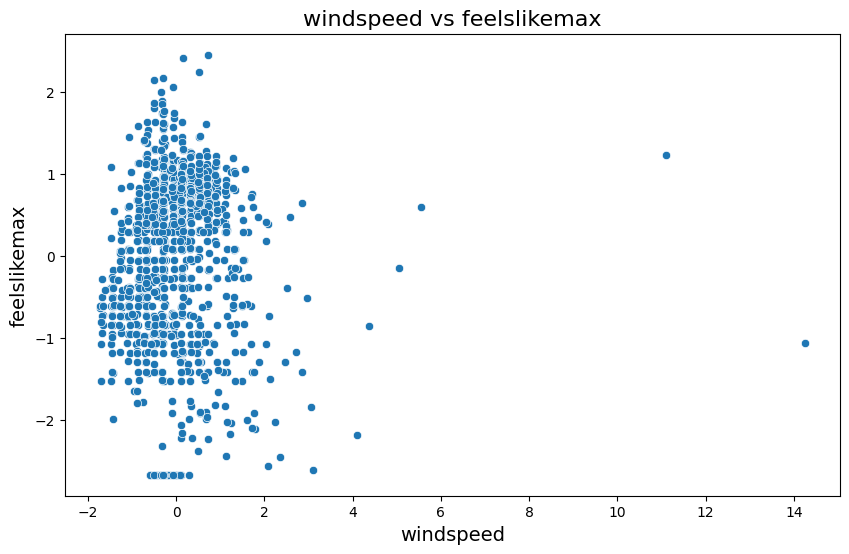

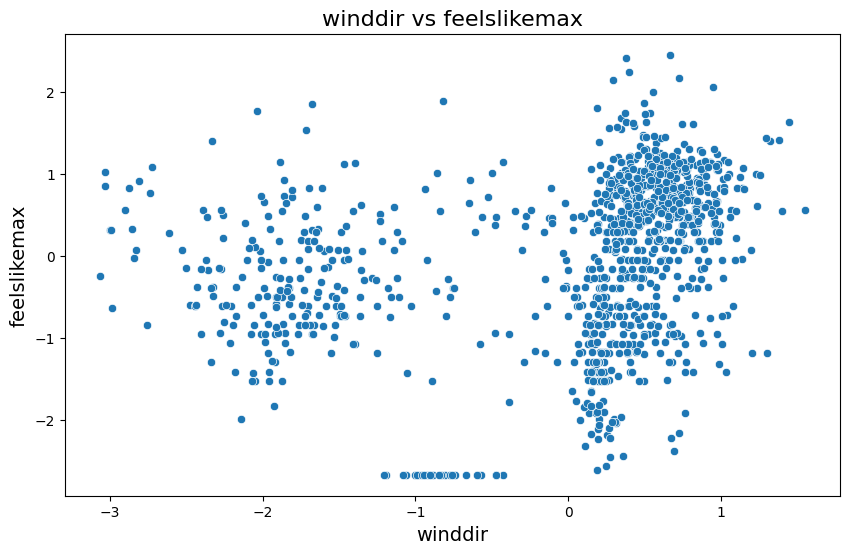

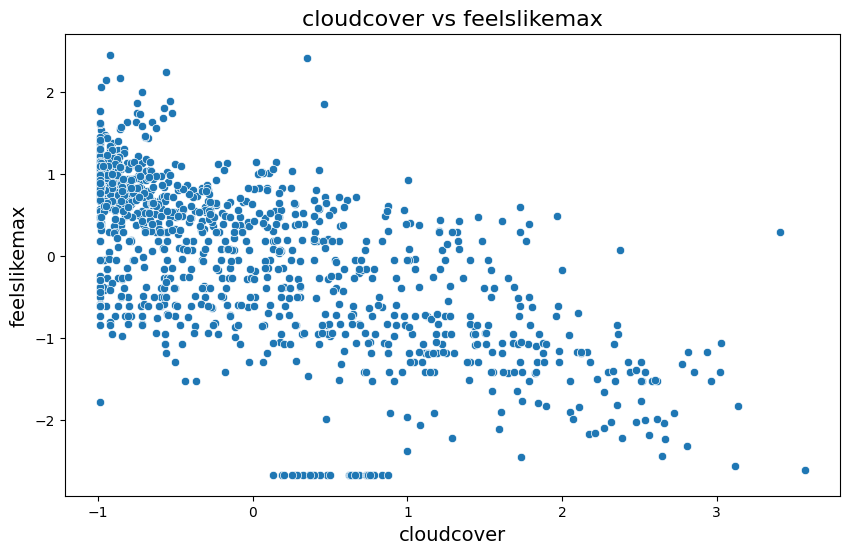

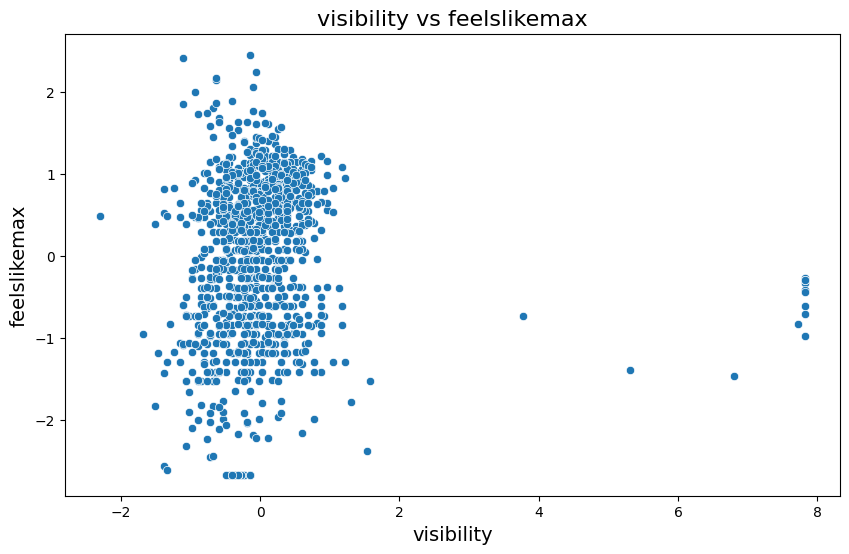

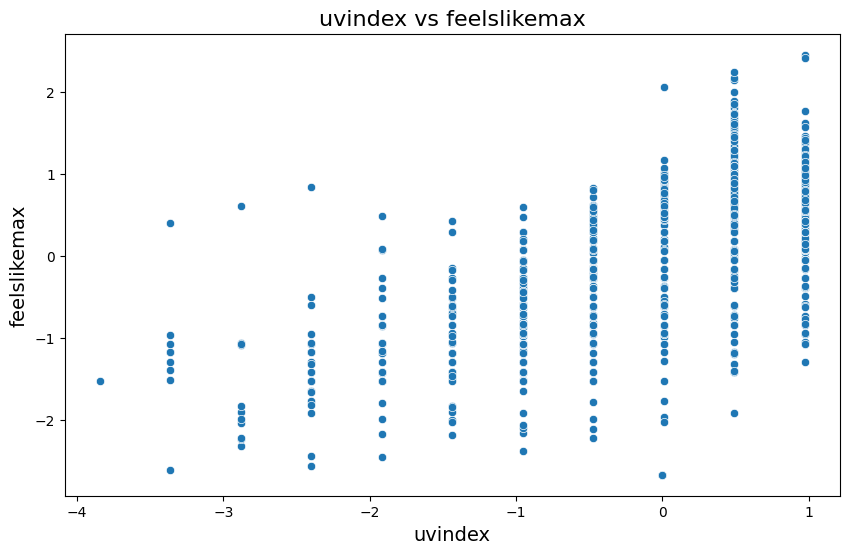

In [199]:
def scatter_with_outliers(data, columns, target):
    for col in columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=data[col], y=data[target])
        plt.title(f'{col} vs {target}', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel(target, fontsize=14)
        plt.show()

scatter_with_outliers(data, columns_with_outliers, 'feelslikemax')


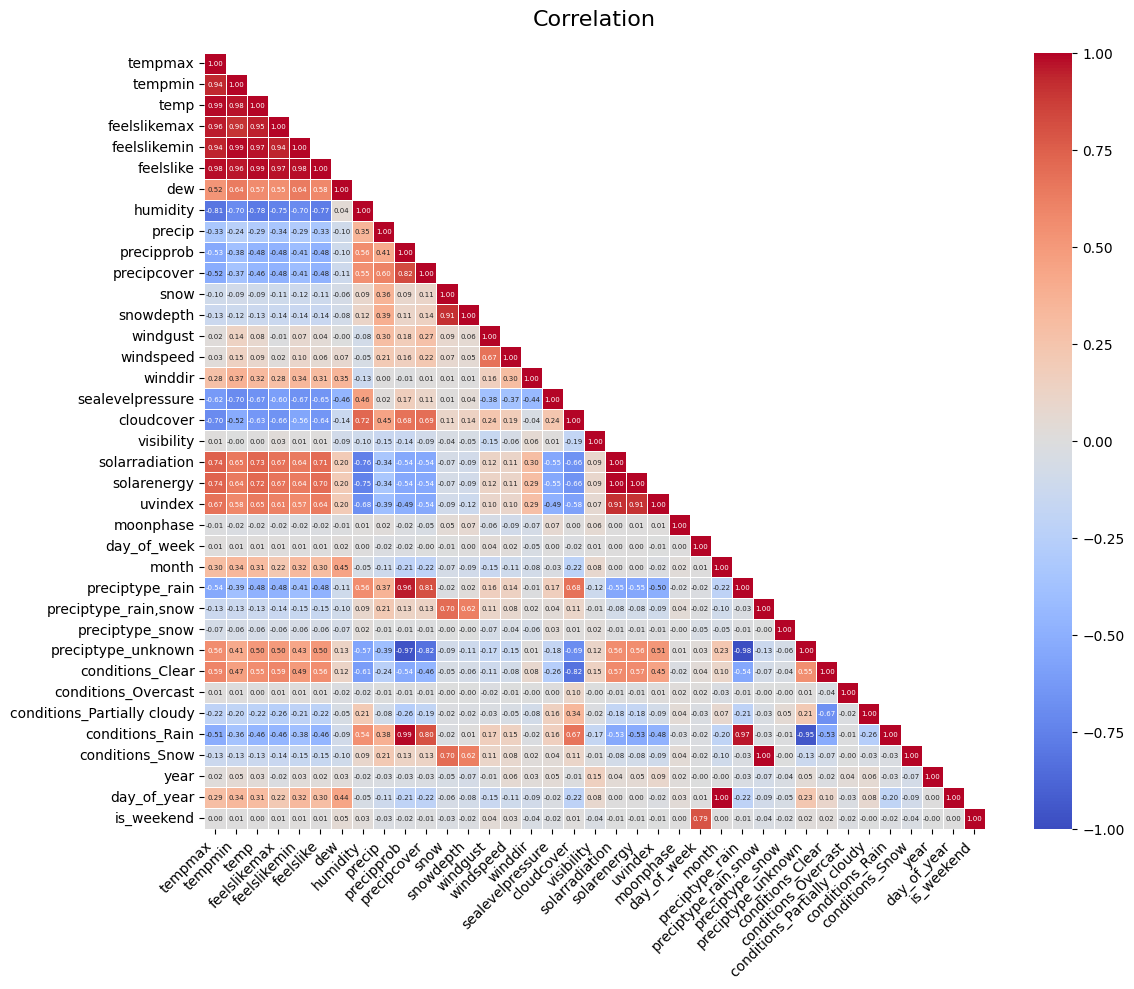

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = data.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    annot_kws={"size": 5},
    linewidths=0.5)

plt.title('Correlation', fontsize=16, pad=20)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


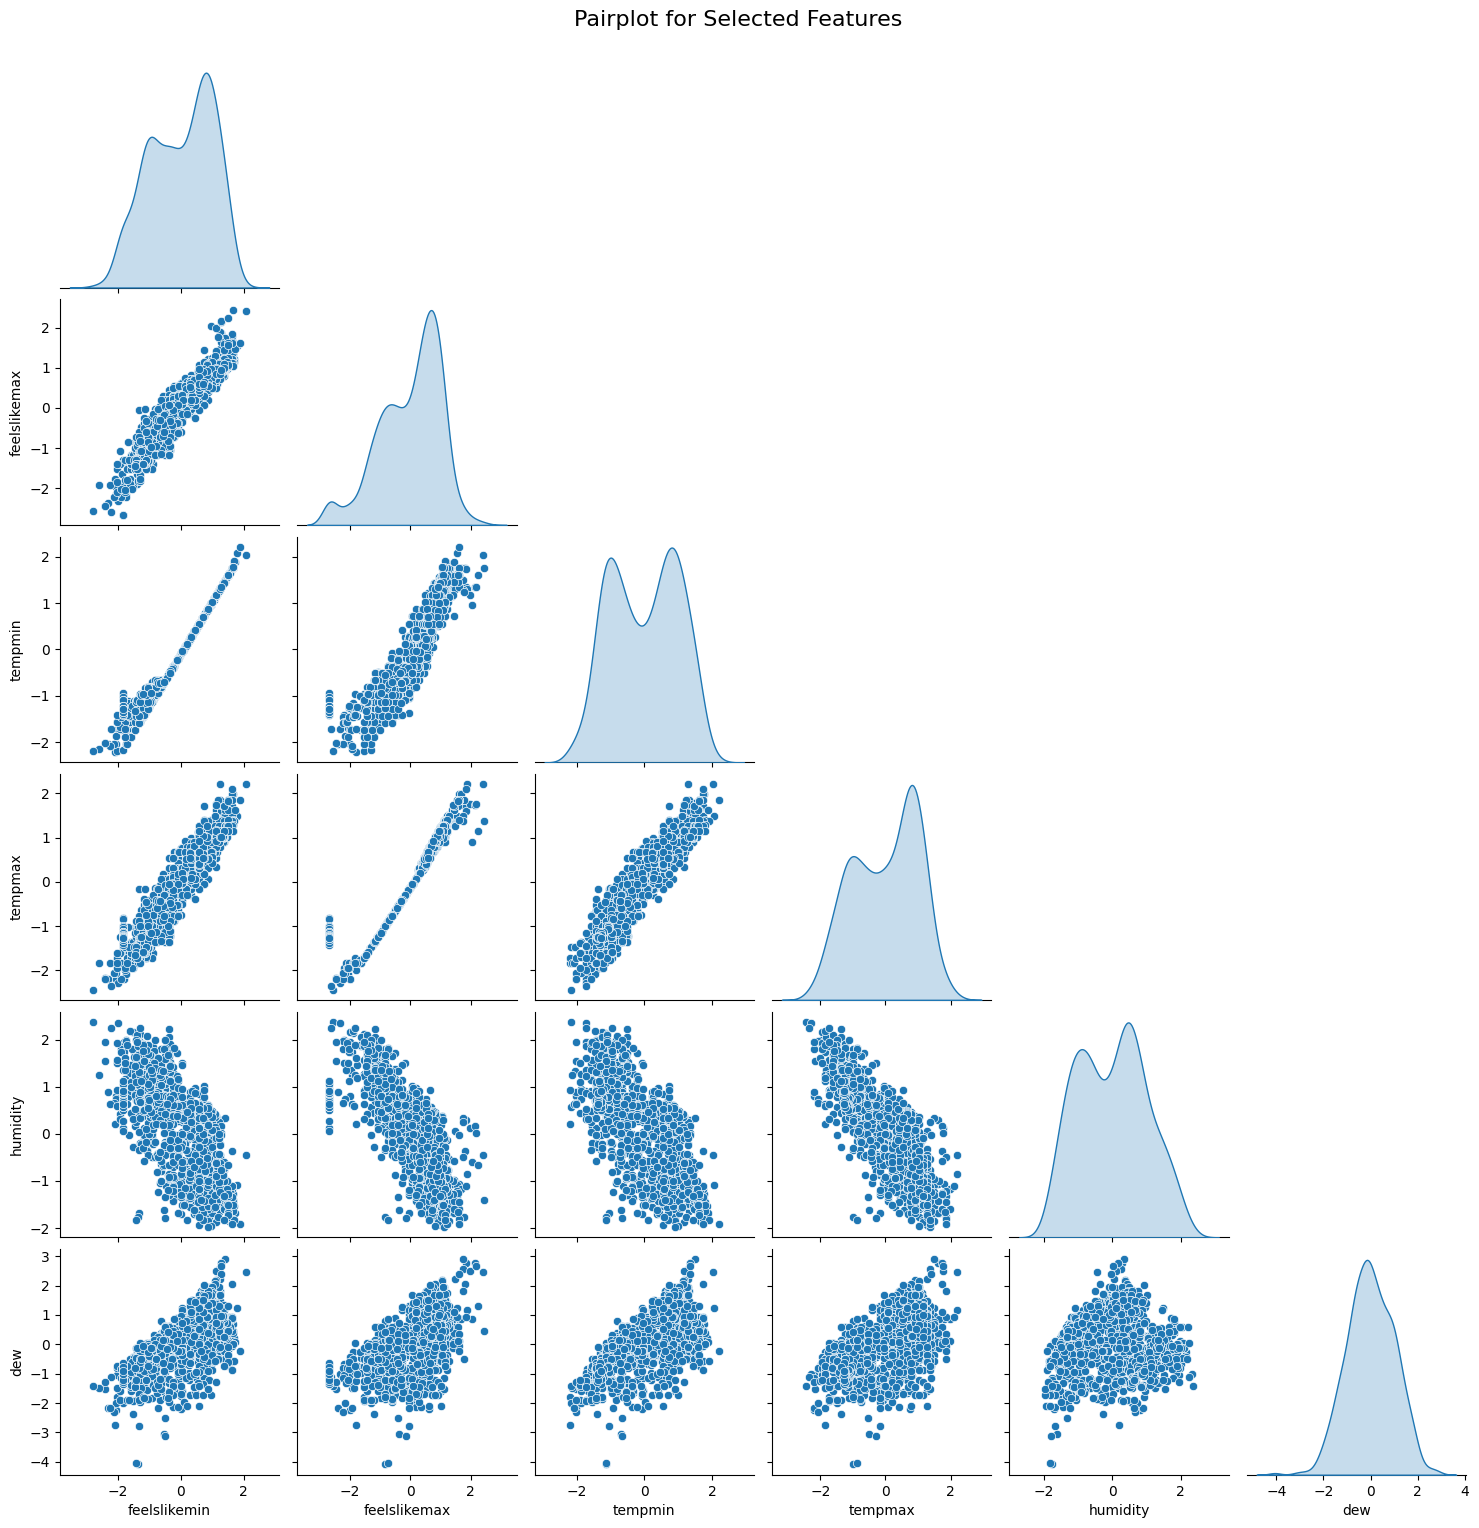

In [177]:
selected_features = ['feelslikemin', 'feelslikemax', 'tempmin', 'tempmax', 'humidity', 'dew']

# Create the pairplot
sns.pairplot(data[selected_features], diag_kind='kde', corner= True)
plt.suptitle('Pairplot for Selected Features', y=1.02, fontsize=16)
plt.show()
